# Lid-driven cavity benchmarkwith a D2Q9 Lattice Boltzmann Method

The code implements a simple D2Q9 LBM, with BGK collision operator and uses a Single Relaxation Time.

The initial Julia implementation comes from [https://github.com/Nappael/JuliaLatticeBoltzmann] (MIT license).

The main reference is of course Philip Mocz's repository [https://github.com/pmocz/latticeboltzmann-python] (GPL3 license).

In [1]:
import Pkg
Pkg.activate(".")
#Pkg.add("PyPlot")
#Pkg.add("Einsum")
#Pkg.add("StaticArrays")
#Pkg.instantiate()

  Activating new environment at `~/hattivatti/Project.toml`


In [49]:
using PyPlot, Einsum, StaticArrays, LinearAlgebra
import Random
Random.seed!(42)
# Simulation parameters
const NL     = 9
const Nx, Ny = 50, 50
const Nt     = 5000
const u0     = 0.1
const ρ0     = 1.0
const Δt     = 1.0
const ΔL     = 1.0
const ν      = 0.01
const τ      = 3ν + 0.5

Re = Nx * abs(u0) / ν
println("Reynolds number Re = ", Re)
const ex = [0, 1, 1, 0,-1,-1,-1, 0, 1]
const ey = [0, 0, 1, 1, 1, 0,-1,-1,-1]
const S  = [1.0, 1.4, 1.4, 1.0, 1.2, 1.0, 1.2, 1/τ, 1/τ]
const M = [1     1     1     1     1     1     1     1     1
          -4    -1     2    -1     2    -1     2    -1     2
           4    -2     1    -2     1    -2     1    -2     1
           0     1     1     0    -1    -1    -1     0     1
           0    -2     1     0    -1     2    -1     0     1
           0     0     1     1     1     0    -1    -1    -1
           0     0     1    -2     1     0    -1     2    -1
           0     1     0    -1     0     1     0    -1     0
           0     0     1     0    -1     0     1     0    -1]
invM = M \ diagm(S)

struct LatticeState{T}
    ρ::Array{T, 2}    # macroscale density
    f::Array{T, 3}    # particle distribution function
    m::Array{T, 3}  # equillibrium moments for collision
    ux::Array{T, 2}   # macroscale velocity, x component
    uy::Array{T, 2}   # macroscale velocity, y component
    meq::Array{T, 3}  # equillibrium term for collision
    tmp::Array{T, 2}  # place-holder array
end

function LatticeState(Nx,Ny)
    ρ   = zeros(Nx,Ny)
    f   = ones(Nx,Ny,NL)
    m   = similar(f)
    ux  = similar(ρ)
    uy  = similar(ρ)
    meq = similar(f)
    tmp = similar(ρ)

    return LatticeState{Float64}(ρ, f, m, ux, uy, meq, tmp)
end

Reynolds number Re = 500.0


LatticeState

In [95]:
@inbounds function stream!(f::Array{<:Real}, tmp::Array{<:Real})
    for i in 1:NL
        A = @view f[:,:,i]
        circshift!(tmp, A, (ex[i],0) )
        circshift!(A, tmp, (0,ey[i]) )
    end
end


@inbounds function calculate_meq!(meq::Array{<:Real},
        ρ::Array{<:Real}, ux::Array{<:Real}, uy::Array{<:Real})
    for i=1:Nx, j=1:Ny
        jx = ρ[i,j] * ux[i,j]
        jy = ρ[i,j] * uy[i,j]
        meq[i,j,1] =    ρ[i,j]
        meq[i,j,2] =-2.0ρ[i,j] + 3.0(jx^2 + jy^2)
        meq[i,j,3] =+1.0ρ[i,j] - 3.0(jx^2 + jy^2)
        meq[i,j,4] =  +jx
        meq[i,j,5] =  -jx
        meq[i,j,6] =  +jy
        meq[i,j,7] =  -jy
        meq[i,j,8] =   jx^2 - jy^2
        meq[i,j,9] =   jx * jy
    end
end

@inbounds function collision!(f::Array{<:Real}, m::Array{<:Real}, meq::Array{<:Real})
    for i=1:Nx, j=1:Ny
        m[i,j,:] .= M * f[i,j,:]
        f[i,j,:] .=     f[i,j,:] .- invM * (m[i,j,:] .- meq[i,j,:])
    end
end

@inbounds function calculate_u!(ux::Array{<:Real}, uy::Array{<:Real},
        f::Array{<:Real}, ρ::Array{<:Real})
    sum!(ρ, f)
    @einsum ux[i,j] = f[i,j,k] * ex[k] / ρ[i,j]
    @einsum uy[i,j] = f[i,j,k] * ey[k] / ρ[i,j]
    
    ux[1,:] .= .0; ux[Nx,:] .= .0; ux[:,1] .= .0; ux[:,Ny] .= u0;
    uy[1,:] .= .0; uy[Nx,:] .= .0; uy[:,1] .= .0; uy[:,Ny] .= .0;
end

@inbounds function correct_f!(f::Array{<:Real}, ρ::Array{<:Real})
    @einsum f[i,j,k] = f[i,j,k] * ρ0 / ρ[i,j]
end

@inbounds function apply_bc!(f::Array{<:Real})
    f[1,:,2] =  f[1,:,6]
    f[1,:,3] =  f[1,:,7]
    f[1,:,9] =  f[1,:,5]
    
    f[Nx,:,6] = f[Nx,:,2]
    f[Nx,:,7] = f[Nx,:,3]
    f[Nx,:,5] = f[Nx,:,9]
    
    f[:,1,4] =  f[:,1,8]
    f[:,1,3] =  f[:,1,7]
    f[:,1,5] =  f[:,1,9]
    
    ρu =    f[:,Ny,1] + f[:,Ny,2] + f[:,Ny,6] +
        2.0(f[:,Ny,4] + f[:,Ny,5] + f[:,Ny,3])
    f[:,Ny,8] = f[:,Ny,4]
    f[:,Ny,9] = f[:,Ny,5] + 0.5(f[:,Ny,6] - f[:,Ny,2]) + 0.5ρu*u0
    f[:,Ny,7] = f[:,Ny,3] + 0.5(f[:,Ny,2] - f[:,Ny,6]) - 0.5ρu*u0
    
    #ρ  = F[:,Ny,1] + F[:,Ny,4] + F[:,Ny,8] + 2.0(F[:,Ny,2] + F[:,Ny,3] + F[:,Ny,9])
    #ρu = u0 .* ρ ./ (1.0 .+ u0)
    #F[:,Ny,5] = F[:,Ny,9] - 1/6*ρu + 1/2*(F[:,Ny,8] - F[:,Ny,4])
    #F[:,Ny,6] = F[:,Ny,2] - 2/3*ρu
    #F[:,Ny,7] = F[:,Ny,3] - 1/6*ρu + 1/2*(F[:,Ny,4] - F[:,Ny,8])
end

function step!(s::LatticeState, Nt::Int)
    for it in 1:Nt
        calculate_meq!(s.meq, s.ρ, s.ux, s.uy)
        collision!(s.f, s.m, s.meq)
        stream!(s.f, s.tmp)
        apply_bc!(s.f)
        calculate_u!(s.ux, s.uy, s.f, s.ρ)
    end
end

@inbounds function init!(s::LatticeState)
    fill!(s.f,  1.0)
    fill!(s.ux, 0.0)
    fill!(s.uy, 0.0)
    sum!(s.ρ, s.f)
    #correct_f!(s.f, s.ρ)
end

init! (generic function with 1 method)

In [96]:
s = LatticeState(Nx, Ny)
init!(s)

50×50 Matrix{Float64}:
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0  …  9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0  …  9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0  …  9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0  

In [97]:
calculate_meq!(s.meq, s.ρ, s.ux, s.uy)
s.meq[:,:,2]

50×50 Matrix{Float64}:
 -18.0  -18.0  -18.0  -18.0  -18.0  …  -18.0  -18.0  -18.0  -18.0  -18.0
 -18.0  -18.0  -18.0  -18.0  -18.0     -18.0  -18.0  -18.0  -18.0  -18.0
 -18.0  -18.0  -18.0  -18.0  -18.0     -18.0  -18.0  -18.0  -18.0  -18.0
 -18.0  -18.0  -18.0  -18.0  -18.0     -18.0  -18.0  -18.0  -18.0  -18.0
 -18.0  -18.0  -18.0  -18.0  -18.0     -18.0  -18.0  -18.0  -18.0  -18.0
 -18.0  -18.0  -18.0  -18.0  -18.0  …  -18.0  -18.0  -18.0  -18.0  -18.0
 -18.0  -18.0  -18.0  -18.0  -18.0     -18.0  -18.0  -18.0  -18.0  -18.0
 -18.0  -18.0  -18.0  -18.0  -18.0     -18.0  -18.0  -18.0  -18.0  -18.0
 -18.0  -18.0  -18.0  -18.0  -18.0     -18.0  -18.0  -18.0  -18.0  -18.0
 -18.0  -18.0  -18.0  -18.0  -18.0     -18.0  -18.0  -18.0  -18.0  -18.0
 -18.0  -18.0  -18.0  -18.0  -18.0  …  -18.0  -18.0  -18.0  -18.0  -18.0
 -18.0  -18.0  -18.0  -18.0  -18.0     -18.0  -18.0  -18.0  -18.0  -18.0
 -18.0  -18.0  -18.0  -18.0  -18.0     -18.0  -18.0  -18.0  -18.0  -18.0
   ⋮                        

In [98]:
collision!(s.f, s.m, s.meq)
s.m[:,:,1]

50×50 Matrix{Float64}:
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0  …  9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0  …  9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0  …  9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0     9.0  9.0  9.0  9.0  9.0  9.0  9.0
 9.0  9.0  9.0  9.0  9.0  9.0  9.0  9.0  

In [99]:
stream!(s.f, s.tmp)
s.f[:,:,1]

50×50 Matrix{Float64}:
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2  …  5.2  5.2  5.2  5.2  5.2  5.2  5.2
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2     5.2  5.2  5.2  5.2  5.2  5.2  5.2
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2     5.2  5.2  5.2  5.2  5.2  5.2  5.2
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2     5.2  5.2  5.2  5.2  5.2  5.2  5.2
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2     5.2  5.2  5.2  5.2  5.2  5.2  5.2
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2  …  5.2  5.2  5.2  5.2  5.2  5.2  5.2
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2     5.2  5.2  5.2  5.2  5.2  5.2  5.2
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2     5.2  5.2  5.2  5.2  5.2  5.2  5.2
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2     5.2  5.2  5.2  5.2  5.2  5.2  5.2
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2     5.2  5.2  5.2  5.2  5.2  5.2  5.2
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2  …  5.2  5.2  5.2  5.2  5.2  5.2  5.2
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2     5.2  5.2  5.2  5.2  5.2  5.2  5.2
 5.2  5.2  5.2  5.2  5.2  5.2  5.2  5.2  

In [100]:
apply_bc!(s.f)
s.f[:,:,2]

50×50 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

In [101]:
calculate_u!(s.ux, s.uy, s.f, s.ρ)
s.ux

50×50 Matrix{Float64}:
 0.0  0.0          0.0          0.0          …  0.0          0.0          0.1
 0.0  1.36176e-16  1.36176e-16  1.36176e-16     1.36176e-16  1.36176e-16  0.1
 0.0  1.36176e-16  1.36176e-16  1.36176e-16     1.36176e-16  1.36176e-16  0.1
 0.0  1.36176e-16  1.36176e-16  1.36176e-16     1.36176e-16  1.36176e-16  0.1
 0.0  1.36176e-16  1.36176e-16  1.36176e-16     1.36176e-16  1.36176e-16  0.1
 0.0  1.36176e-16  1.36176e-16  1.36176e-16  …  1.36176e-16  1.36176e-16  0.1
 0.0  1.36176e-16  1.36176e-16  1.36176e-16     1.36176e-16  1.36176e-16  0.1
 0.0  1.36176e-16  1.36176e-16  1.36176e-16     1.36176e-16  1.36176e-16  0.1
 0.0  1.36176e-16  1.36176e-16  1.36176e-16     1.36176e-16  1.36176e-16  0.1
 0.0  1.36176e-16  1.36176e-16  1.36176e-16     1.36176e-16  1.36176e-16  0.1
 0.0  1.36176e-16  1.36176e-16  1.36176e-16  …  1.36176e-16  1.36176e-16  0.1
 0.0  1.36176e-16  1.36176e-16  1.36176e-16     1.36176e-16  1.36176e-16  0.1
 0.0  1.36176e-16  1.36176e-16  1.36176e-

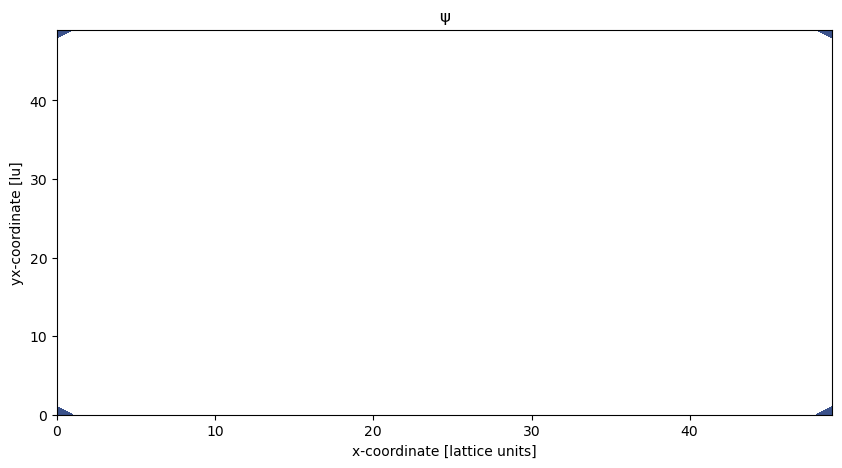

 11.485494 seconds (125.20 M allocations: 14.613 GiB, 6.04% gc time, 0.09% compilation time)


PyObject Text(23.999999999999993, 0.5, 'yx-coordinate [lu]')

In [102]:
# problem  = LatticeState(Nx, Ny)
init!(problem)
@time step!(problem,  5000) # Run simulation the first time to get rid of compilation overhead
#@time step!(problem, 10) # Run simulation (for real!)
ψ = zeros(Nx, Ny)
for i=2:Nx-1, j=2:Ny-1
    ψ[i,j] = ψ[i-1,j] - problem.uy[i,j]
end
figure(figsize=(10,5))
#imshow(problem.ρ'); title("Density ρ")
contourf(ψ'); title("ψ")
#imshow(problem.ux'); title("Horizontal velocity")
xlabel("x-coordinate [lattice units]")
ylabel("yx-coordinate [lu]")

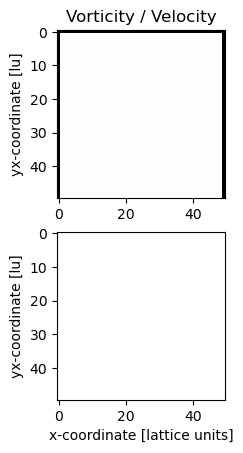

/Users/bach/.julia/conda/3/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/bach/.julia/conda/3/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


PyObject Text(23.999999999999993, 0.5, 'yx-coordinate [lu]')

In [5]:
ux = copy(problem.ux)
uy = copy(problem.uy)
velocity  = ux .^2 .+ uy .^ 2
vorticity = (circshift(ux, (0,+1)) .- circshift(ux, (0,-1))) .-
            (circshift(uy, (+1,0)) .- circshift(uy, (-1,0)))
vorticity[1,:] .= NaN
vorticity[:,1] .= NaN
vorticity[Nx,:].= NaN
bwr = PyPlot.cm.bwr.copy(); bwr.set_bad("black")

subplot(2,1,1); imshow(vorticity', cmap=bwr); clim([-.03, +.03]);
title("Vorticity / Velocity")
ylabel("yx-coordinate [lu]")
subplot(2,1,2); imshow(log10.(abs.(velocity')))
xlabel("x-coordinate [lattice units]")
ylabel("yx-coordinate [lu]")

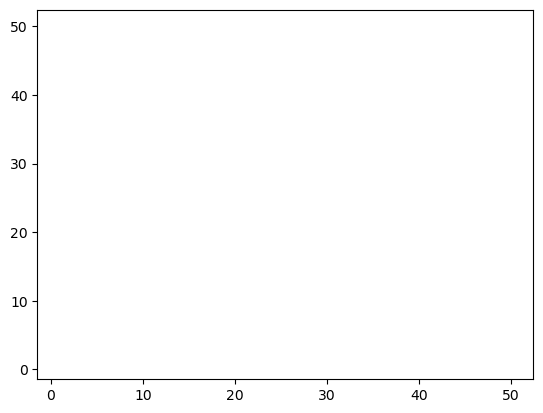

/Users/bach/.julia/conda/3/lib/python3.9/site-packages/matplotlib/quiver.py:679: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/bach/.julia/conda/3/lib/python3.9/site-packages/matplotlib/quiver.py:679: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


PyObject <matplotlib.quiver.Quiver object at 0x7fb072230ac0>

In [6]:
quiver([i for i=1:Nx, j=1:Ny], [j for i=1:Nx, j=1:Ny], problem.ux, problem.uy)

In [94]:
ψ

50×50 Matrix{Float64}:
 0.0    0.0    0.0    0.0    0.0    0.0  …    0.0    0.0    0.0    0.0  0.0
 0.0  NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    0.0
 0.0  NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    0.0
 0.0  NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    0.0
 0.0  NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    0.0
 0.0  NaN    NaN    NaN    NaN    NaN    …  NaN    NaN    NaN    NaN    0.0
 0.0  NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    0.0
 0.0  NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    0.0
 0.0  NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    0.0
 0.0  NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    0.0
 0.0  NaN    NaN    NaN    NaN    NaN    …  NaN    NaN    NaN    NaN    0.0
 0.0  NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    0.0
 0.0  NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    